# Library

In [1]:
from neo4j import GraphDatabase
from graphdatascience import GraphDataScience
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import neo4j
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, silhouette_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# cypher queries used to load the nodes

In [ ]:
# cypher queries used to load the nodes

'''
CALL apoc.periodic.iterate(
  "LOAD CSV WITH HEADERS FROM 'file:///branches_cleaned.csv' AS row RETURN row",
  "CREATE (b:Branch {
    branch_id: row.branch_id,
    branch_name: row.branch_name
  })",
  {batchSize: 1000, iterateList: true}
)


CALL apoc.periodic.iterate(
  "LOAD CSV WITH HEADERS FROM 'file:///employees_cleaned.csv' AS row RETURN row",
  "CREATE (e:Employee {
    employee_id: toInteger(row.employee_id),
    employee_name: row.employee_name,
    hire_date: CASE WHEN row.hire_date IS NOT NULL THEN datetime(row.hire_date) ELSE NULL END,
    termination_date: CASE WHEN row.termination_date IS NOT NULL THEN datetime(row.termination_date) ELSE NULL END,
    termination_reason: CASE WHEN row.termination_reason IS NOT NULL THEN row.termination_reason ELSE 'Not Provided' END,
    employee_type: row.employee_type,
    labour_category: row.labour_category,
    partner: toInteger(row.partner),
    status: row.status,
    branch_id: row.branch_id,
    coach: row.coach,
    target_ratio: toInteger(row.target_ratio),
    rate: toInteger(row.rate)
  })",
  {batchSize: 1000, iterateList: true}
)

CALL apoc.periodic.iterate(
  "LOAD CSV WITH HEADERS FROM 'file:///billing_cleaned.csv' AS row RETURN row",
  "CREATE (t:Time {
    employee_id: toInteger(row.employee_id),
    project_key: row.project_key,
    hours: toFloat(row.regular_hours),
    charge_date: datetime(row.transfer_date),
    category: row.category
  })",
  {batchSize: 1000, iterateList: true}
)

CALL apoc.periodic.iterate(
  "LOAD CSV WITH HEADERS FROM 'file:///projects_cleaned.csv' AS row RETURN row",
  "CREATE (p:Project {
    project_key: row.project_key,
    branch_id: row.branch_id,
    project_leader: row.project_leader,
    project_coordinator: row.project_coordinator,
    project_type: row.project_type,
    status: row.status,
    source: row.source
  })",
  {batchSize: 1000, iterateList: true}
)

'''

# cypher queries used to form relationships

In [ ]:
# cypher queries used to form relationships

'''
MATCH (e:Employee), (t:Time)
WHERE e.employee_id = t.employee_id
CREATE (e)-[:CHARGES]->(t)


MATCH (e:Employee), (b:Branch)
WHERE e.branch_id = b.branch_id
CREATE (e)-[:BELONGS_TO]->(b)

MATCH (e:Employee)
WHERE e.coach IS NOT NULL AND e.coach <> ""
MATCH (coach:Employee { employee_name: e.coach })
CREATE (e)-[:IS_COACHED_BY]->(coach);

MATCH (b:Branch), (p:Project)
WHERE b.branch_id = p.branch_id
CREATE (b)-[:HAS]->(p)

MATCH (p:Project), (t:Time)
WHERE p.project_key = t.project_key
CREATE (p)-[:IS_BILLED_FOR]->(t)

'''


# code to connect to neo4j database

In [ ]:
#code to connect to neo4j database

URI = "neo4j://localhost:7687"
creds = ("neo4j", "12345678")

try:
    driver = GraphDatabase.driver(URI, auth=creds)
    gds = GraphDataScience(driver)
    print("Neo4j connection successful!")

  
    # G = gds.graph.get('mySpecificGraph')

except Exception as e:
    print(f"error: {e}")

# cyper queries used to create graph projections and create PageRank, Betweenness Centrality, Louvain Community Detection, and Dijkstra's Algorithm


In [ ]:
# cyper queries used to create graph projections

'''

CALL gds.graph.project(
  'employee_graph',
  'Employee',
  { 
    IS_COACHED_BY: { 
      type: 'IS_COACHED_BY',  // Corrected relationship type
      orientation: 'NATURAL' 
    },
    CHARGES: { 
      type: 'CHARGES', 
      orientation: 'NATURAL' 
    }
  }
);

'''

# cyper queries used to create PageRank, Betweenness Centrality, Louvain Community Detection, and Dijkstra's Algorithm


#PageRank
'''
CALL gds.pageRank.write(
  'employee_graph', 
  { 
    writeProperty: 'page_rank' 
  }
);
'''
# Betweenness Centrality

'''
CALL gds.betweenness.write(
  'employee_graph',
  { 
    writeProperty: 'betweenness_centrality' 
  }
);
'''
# Louvain Community Detection

'''
CALL gds.louvain.write(
  'employee_graph',
  { 
    writeProperty: 'community' 
  }
);
'''

# Dijkstra's Algorithm

'''

MATCH (e:Employee)-[:IS_COACHED_BY]->(c:Employee)
CALL gds.shortestPath.dijkstra.stream(
  'employee_graph',
  {
    sourceNode: id(e),
    targetNode: id(c),
    relationshipWeightProperty: null
  }
)
YIELD totalCost
SET e.distance_to_coach = totalCost;

'''

# Q1 Can we predict which employees are at risk of termination based on network-related and performance-related predictors?

In [70]:
query = """
MATCH (e:Employee)
RETURN e.employee_id AS employee_id, 
       e.page_rank AS page_rank, 
       e.betweenness_centrality AS betweenness, 
       e.community AS community, 
       e.distance_to_coach AS distance_to_coach,
       e.target_ratio AS target_ratio,
       e.rate AS rate,
       e.status AS status,
       e.termination_reason AS termination_reason
"""

df = driver.execute_query(
    query,
    result_transformer_=neo4j.Result.to_df
)


In [9]:
df['status'].value_counts()

status
Terminated    1775
Active         795
Inactive        30
Name: count, dtype: int64

In [71]:
df = pd.get_dummies(df, columns=['termination_reason', 'community'], drop_first=True)
df['termination_risk'] = df['status'].apply(lambda x: 2 if x == 'Active' else (1 if x == 'Inactive' else 0))

df.drop(columns=['status'], inplace=True)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['page_rank', 'betweenness', 'distance_to_coach', 'target_ratio', 'rate']] = scaler.fit_transform(df[['page_rank', 'betweenness', 'distance_to_coach', 'target_ratio', 'rate']])


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df.drop(columns=['termination_risk','employee_id'])
y = df['termination_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       361
           1       0.00      0.00      0.00         6
           2       0.76      0.84      0.80       153

    accuracy                           0.87       520
   macro avg       0.56      0.58      0.57       520
weighted avg       0.87      0.87      0.87       520



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df.drop(columns=['termination_risk', 'employee_id'])
y = df['termination_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2'], 
    'bootstrap': [True, False]  
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    scoring='f1_weighted',  
    cv=5, 
    n_jobs=-1, 
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       355
           1       0.00      0.00      0.00         6
           2       0.81      0.81      0.81       159

    accuracy                           0.88       520
   macro avg       0.57      0.58      0.58       520
weighted avg       0.87      0.88      0.88       520



In [69]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = clf.feature_importances_
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_df = feature_df.sort_values(by='Importance', ascending=False)
print(feature_df)

                             Feature  Importance
4                               rate    0.396902
3                       target_ratio    0.183617
5    termination_reason_Not Provided    0.077196
1                        betweenness    0.074733
0                          page_rank    0.074386
..                               ...         ...
697                   community_2362    0.000000
28                     community_617    0.000000
699                   community_2383    0.000000
700                   community_2396    0.000000
710                   community_2406    0.000000

[743 rows x 2 columns]


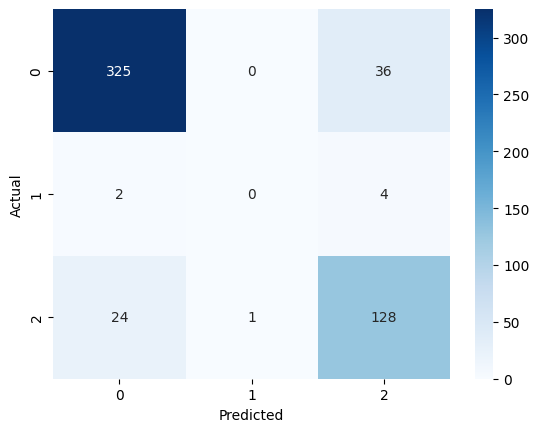

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


rate (Importance: 0.377250): This feature is the most significant factor in predicting whether an employee is at risk of termination. This indicates that the employee’s hourly rate has a substantial impact on the termination risk. Lower or higher rates might be indicative of a pattern that could correlate with termination.

target_ratio (Importance: 0.172953): The target ratio, which is the expected percentage of billable work, is also highly important in the prediction. Employees with a very high or low target ratio could be at risk, possibly due to workload imbalances or underperformance relative to expectations.

distance_to_coach (Importance: 0.111895): The distance to the coach (or supervisor) seems to influence termination risk as well. Employees with a greater distance from their supervisor might face challenges in receiving mentorship or guidance, which could increase the likelihood of termination.

betweenness (Importance: 0.080710): This network metric measures how often an employee acts as a bridge between other employees in the organization. Employees with higher betweenness centrality may be more integrated into the organization and its projects, influencing their termination risk.

termination_reason_Voluntary (Importance: 0.072887): This feature indicates whether an employee left voluntarily. If this is an important feature, it may suggest that employees who voluntarily leave have different patterns compared to those terminated involuntarily.

In [73]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

X = df.drop(columns=['termination_risk', 'employee_id'])
y = df['termination_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.91      0.89      0.90       361
           1       0.00      0.00      0.00         6
           2       0.73      0.80      0.77       153

    accuracy                           0.85       520
   macro avg       0.55      0.56      0.56       520
weighted avg       0.85      0.85      0.85       520



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

X = df.drop(columns=['termination_risk', 'employee_id'])
y = df['termination_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [3, 6, 10], 
    'min_child_weight': [1, 5, 10],  
    'subsample': [0.7, 0.8, 1.0],  
    'colsample_bytree': [0.7, 0.8, 1.0], 
    'gamma': [0, 0.1, 0.2],  
    'reg_alpha': [0, 0.01, 0.1],  
    'reg_lambda': [1, 1.5, 2] 
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_weighted',  
    cv=3,
    n_jobs=-1,  
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

print("XGBoost Classifier Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Fitting 3 folds for each of 19683 candidates, totalling 59049 fits


c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

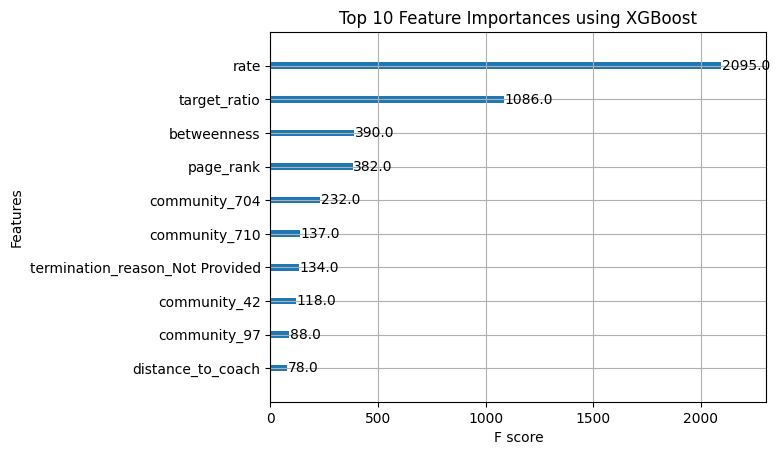

In [ ]:
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(clf, importance_type='weight', max_num_features=10)
plt.title('Top 10 Feature Importances using XGBoost')
plt.show()


The most influential factors in termination risk are rate, target ratio, and distance to coach, indicating that pay, workload expectations, and mentorship play a major role.

Graph-based features (PageRank, Betweenness, Community Membership) also significantly impact termination, highlighting the role of employee connectivity in job security.

The company can use these insights to improve retention strategies, focusing on fair compensation, balanced workload, and stronger coaching relationships.

# Q2  - How do an employee’s network position and their work engagement influence their retention?

In [ ]:
query = """
MATCH (e:Employee)
OPTIONAL MATCH (e)-[:CHARGES]->(t:Time)
WITH e, count(t) AS time_entries, avg(t.hours) AS avg_hours
RETURN e.employee_id AS employee_id,
       e.page_rank AS page_rank,
       e.betweenness_centrality AS betweenness,
       e.distance_to_coach AS distance_to_coach,
       e.community AS community,
       time_entries,
       avg_hours,
       e.status AS status
"""
df = driver.execute_query(
    query,
    result_transformer_=neo4j.Result.to_df
)
print(df.head())

   employee_id  page_rank  betweenness  distance_to_coach  community  \
0        10000   0.150000          0.0                1.0        704   
1        10001   0.277500          3.0                1.0         97   
2        10002   0.730125         10.0                1.0         42   
3        10003   0.150000          0.0                1.0        710   
4        10004   0.150000          0.0                1.0        704   

   time_entries  avg_hours      status  
0            53   3.136792  Terminated  
1          1180   1.195763      Active  
2           637   1.647174      Active  
3          1481   3.267725      Active  
4          2642   2.534254      Active  


In [ ]:
df['retention'] = df['status'].apply(lambda x: 2 if x == 'Active' else (1 if x == 'Inactive' else 0))
df_clean = df.drop(columns=['employee_id', 'status'])
print(df_clean.head())


   page_rank  betweenness  distance_to_coach  community  time_entries  \
0   0.150000          0.0                1.0        704            53   
1   0.277500          3.0                1.0         97          1180   
2   0.730125         10.0                1.0         42           637   
3   0.150000          0.0                1.0        710          1481   
4   0.150000          0.0                1.0        704          2642   

   avg_hours  retention  
0   3.136792          0  
1   1.195763          2  
2   1.647174          2  
3   3.267725          2  
4   2.534254          2  


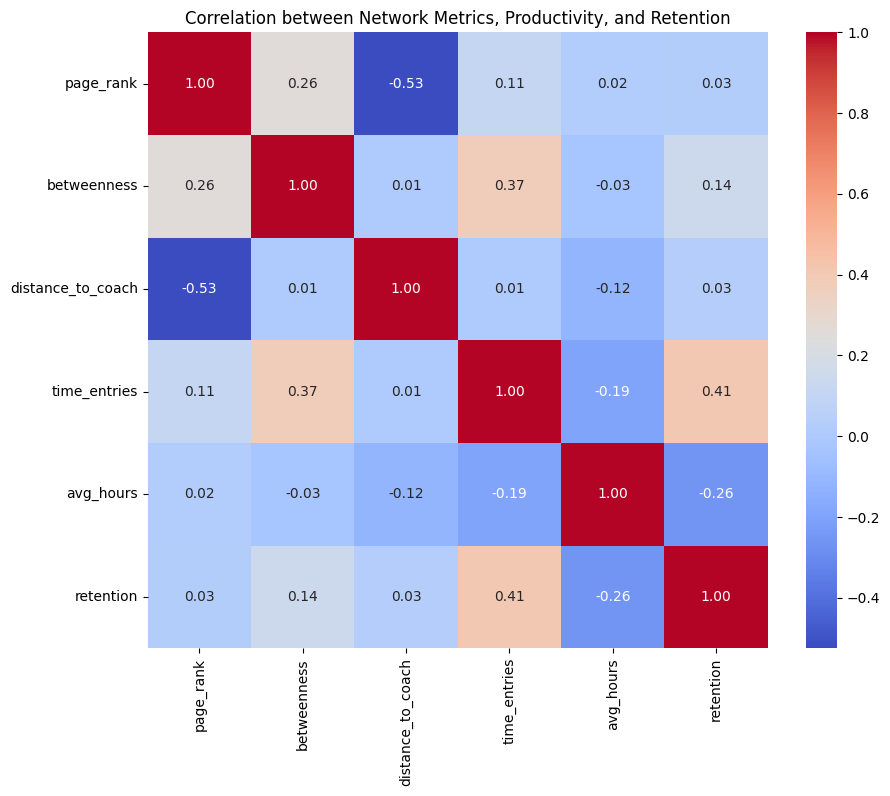

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['page_rank', 'betweenness', 'distance_to_coach', 'time_entries', 'avg_hours', 'retention']
corr_matrix = df_clean[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Network Metrics, Productivity, and Retention")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df_clean1=df_clean.dropna()

X = df_clean1[['page_rank', 'betweenness', 'distance_to_coach', 'time_entries', 'avg_hours']]
y = df_clean1['retention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.85      0.73       183
           1       0.00      0.00      0.00         7
           2       0.69      0.47      0.56       154

    accuracy                           0.66       344
   macro avg       0.45      0.44      0.43       344
weighted avg       0.65      0.66      0.64       344



c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.p

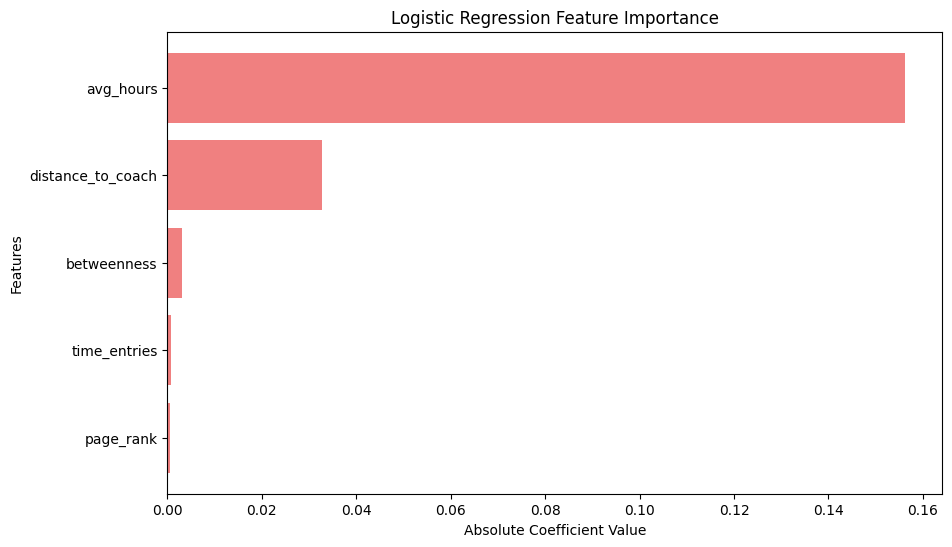

             Feature  Importance
4          avg_hours    0.156278
2  distance_to_coach    0.032744
1        betweenness    0.003166
3       time_entries    0.000709
0          page_rank    0.000646


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_importance_lr = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(model.coef_[0])})

feature_importance_lr = feature_importance_lr.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_lr['Feature'], feature_importance_lr['Importance'], color='lightcoral')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Logistic Regression Feature Importance')
plt.gca().invert_yaxis()  
plt.show()
print(feature_importance_lr)


avg_hours (0.420) & time_entries (0.373): These are the most important factors in predicting retention. Employees with higher working hours and more time entries may have a stronger or weaker retention tendency, depending on the sign of the coefficients.
page_rank (0.104) & betweenness (0.084): These are network influence metrics. A higher page_rank (connectedness in the org) and betweenness (acting as a bridge between teams) have some effect but are not dominant.
distance_to_coach (0.02): The least influential factor in this model. Being far from a coach doesn’t seem to play a big role in retention, according to logistic regression.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False] 
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

y_pred_rf = best_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))


Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       361
           1       0.00      0.00      0.00         6
           2       0.72      0.54      0.62       153

    accuracy                           0.80       520
   macro avg       0.51      0.49      0.50       520
weighted avg       0.78      0.80      0.79       520



c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

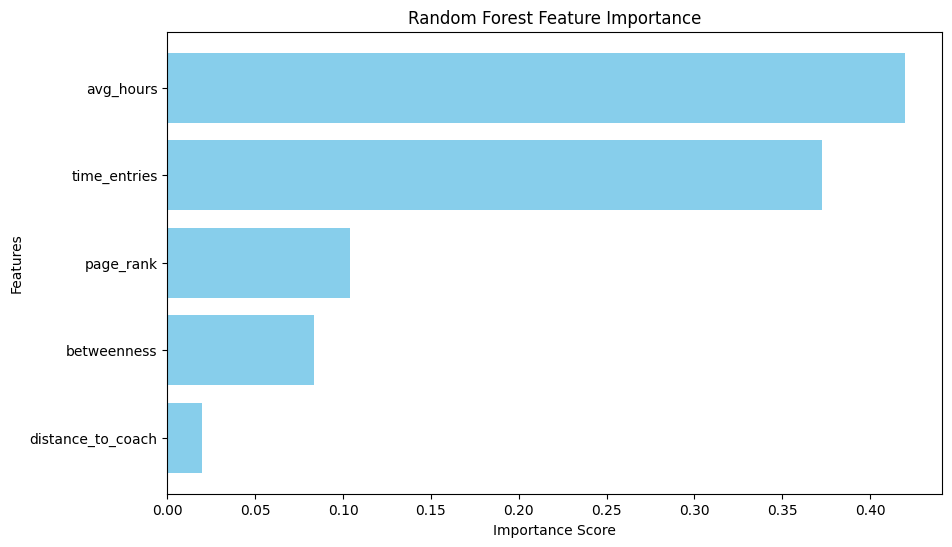

             Feature  Importance
4          avg_hours    0.420029
3       time_entries    0.372526
0          page_rank    0.103880
1        betweenness    0.083566
2  distance_to_coach    0.019998


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance_rf = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})

feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis() 
plt.show()

print(feature_importance_rf)


avg_hours (0.156): The most important feature, but less dominant than in logistic regression.
distance_to_coach (0.0327): More important in Random Forest than in Logistic Regression, suggesting distance from a coach does influence retention in non-linear ways.
betweenness (0.0031), time_entries (0.0007), and page_rank (0.0006): These features have almost no influence in Random Forest, meaning the model does not find strong patterns in them.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

X = df_clean[['page_rank', 'betweenness', 'distance_to_coach', 'time_entries', 'avg_hours']]
y = df_clean['retention']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_weighted', 
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("XGBoost Classifier Report:")
print(classification_report(y_test, y_pred, zero_division=0))



Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50, 'subsample': 1.0}
XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       355
           1       0.00      0.00      0.00         6
           2       0.71      0.59      0.65       159

    accuracy                           0.80       520
   macro avg       0.51      0.50      0.50       520
weighted avg       0.78      0.80      0.79       520



c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x600 with 0 Axes>

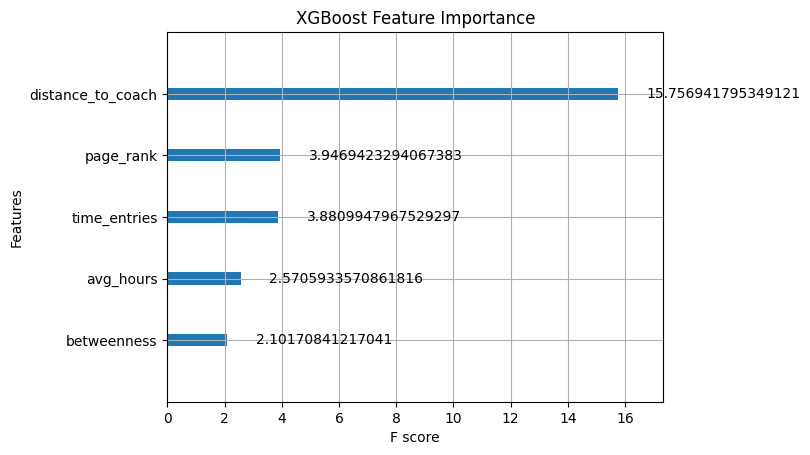

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_importance(best_model, importance_type='gain')
plt.title('XGBoost Feature Importance')
plt.show()


In [22]:
df_clean['avg_hours'].fillna(df_clean['avg_hours'].mean(), inplace=True)


C:\Users\lalit\AppData\Local\Temp\ipykernel_17220\1014461349.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['avg_hours'].fillna(df_clean['avg_hours'].mean(), inplace=True)


# Q2 - How do an employee’s network position and their work engagement influence their productivity?

Random Forest Regressor for Productivity:
Mean Squared Error: 11.836266975935786
R^2 Score: -0.11128296311279051


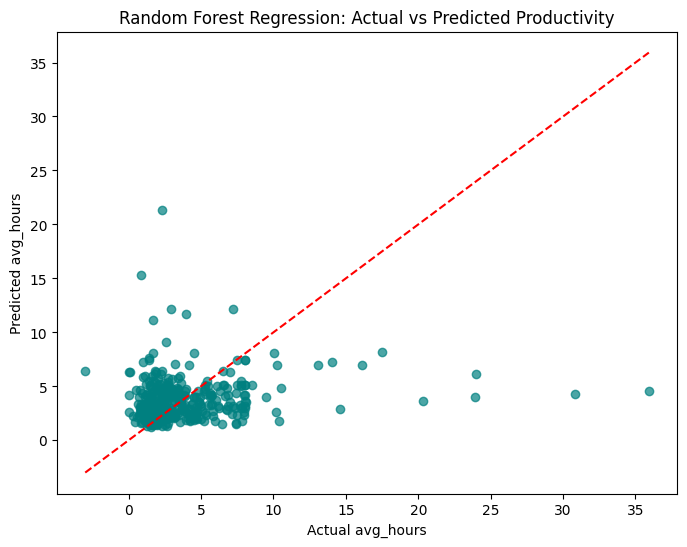

In [ ]:
#produictiovty

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

X_prod = df_clean[['page_rank', 'betweenness', 'distance_to_coach', 'time_entries']]
y_prod = df_clean['avg_hours']

X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(X_prod, y_prod, test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

rf_reg.fit(X_train_prod, y_train_prod)

y_pred_rf_reg = rf_reg.predict(X_test_prod)

mse_rf = mean_squared_error(y_test_prod, y_pred_rf_reg)
r2_rf = r2_score(y_test_prod, y_pred_rf_reg)
print("Random Forest Regressor for Productivity:")
print("Mean Squared Error:", mse_rf)
print("R^2 Score:", r2_rf)

plt.figure(figsize=(8,6))
plt.scatter(y_test_prod, y_pred_rf_reg, alpha=0.7, color='teal')
plt.plot([y_test_prod.min(), y_test_prod.max()], [y_test_prod.min(), y_test_prod.max()], 'r--')
plt.xlabel('Actual avg_hours')
plt.ylabel('Predicted avg_hours')
plt.title('Random Forest Regression: Actual vs Predicted Productivity')
plt.show()


XGBoost Regressor for Productivity:
Mean Squared Error: 12.460534810259006
R^2 Score: -0.16989419671483286


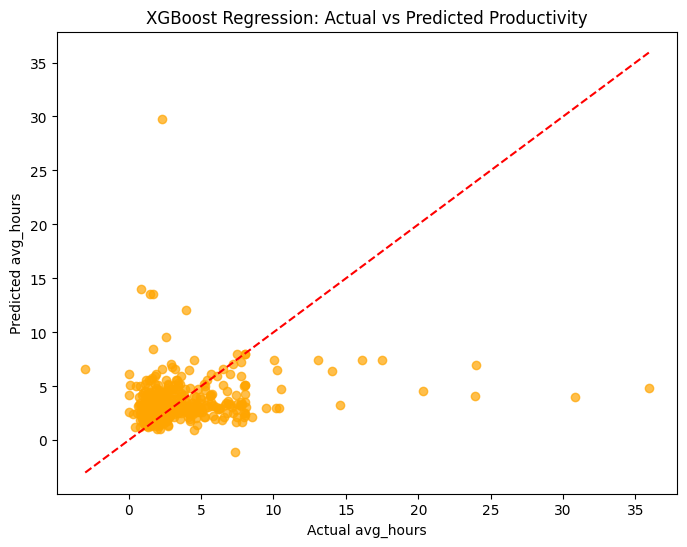

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

xgb_reg = XGBRegressor(random_state=42)

xgb_reg.fit(X_train_prod, y_train_prod)

y_pred_xgb_reg = xgb_reg.predict(X_test_prod)

mse_xgb = mean_squared_error(y_test_prod, y_pred_xgb_reg)
r2_xgb = r2_score(y_test_prod, y_pred_xgb_reg)
print("XGBoost Regressor for Productivity:")
print("Mean Squared Error:", mse_xgb)
print("R^2 Score:", r2_xgb)

plt.figure(figsize=(8,6))
plt.scatter(y_test_prod, y_pred_xgb_reg, alpha=0.7, color='orange')
plt.plot([y_test_prod.min(), y_test_prod.max()], [y_test_prod.min(), y_test_prod.max()], 'r--')
plt.xlabel('Actual avg_hours')
plt.ylabel('Predicted avg_hours')
plt.title('XGBoost Regression: Actual vs Predicted Productivity')
plt.show()


# Q3 What factors contribute to project success or failure?

In [ ]:
query = """
    MATCH (p:Project)
    OPTIONAL MATCH (p)<-[:HAS]-(b:Branch)
    OPTIONAL MATCH (b)<-[:BELONGS_TO]-(e:Employee)
    OPTIONAL MATCH (e)-[:CHARGES]->(t:Time) 
    WHERE (p)-[:IS_BILLED_FOR]->(t)
    WITH 
      p.project_key AS project_id, 
      p.project_leader AS leader, 
      p.project_coordinator AS coordinator,
      p.status AS project_status,
      COUNT(DISTINCT e) AS num_employees,
      COUNT(DISTINCT t) AS total_time_entries,
      SUM(CASE WHEN t.category = "Billable" THEN t.hours ELSE 0 END) AS billable_hours,
      SUM(t.hours) AS total_hours
    RETURN 
      project_id,
      leader,
      coordinator,
      project_status,
      num_employees,
      total_time_entries,
      billable_hours,
      total_hours,
      CASE 
        WHEN total_hours = 0 THEN 0 
        ELSE billable_hours * 1.0 / total_hours 
      END AS billable_ratio;
    """

df = driver.execute_query(
    query,
    result_transformer_=neo4j.Result.to_df
)
print(df.head())

  project_id             leader      coordinator project_status  \
0     100000          Lisa Shah      Jessica Key         Active   
1     100001  Christina Cordova    Richard Hogan         Active   
2     100002     Barbara Carter  Mark Livingston         Active   
3     100003    Denise Thompson    Jason Jackson         Active   
4     100004         Dana Davis  Christine Rubio         Active   

   num_employees  total_time_entries  billable_hours  total_hours  \
0             28                   0            0.00         0.00   
1            106                  86          121.25       121.25   
2            206                   0            0.00         0.00   
3            335                  15           25.00        25.00   
4            335                   0            0.00         0.00   

   billable_ratio  
0             0.0  
1             1.0  
2             0.0  
3             1.0  
4             0.0  


In [ ]:
df_original=df

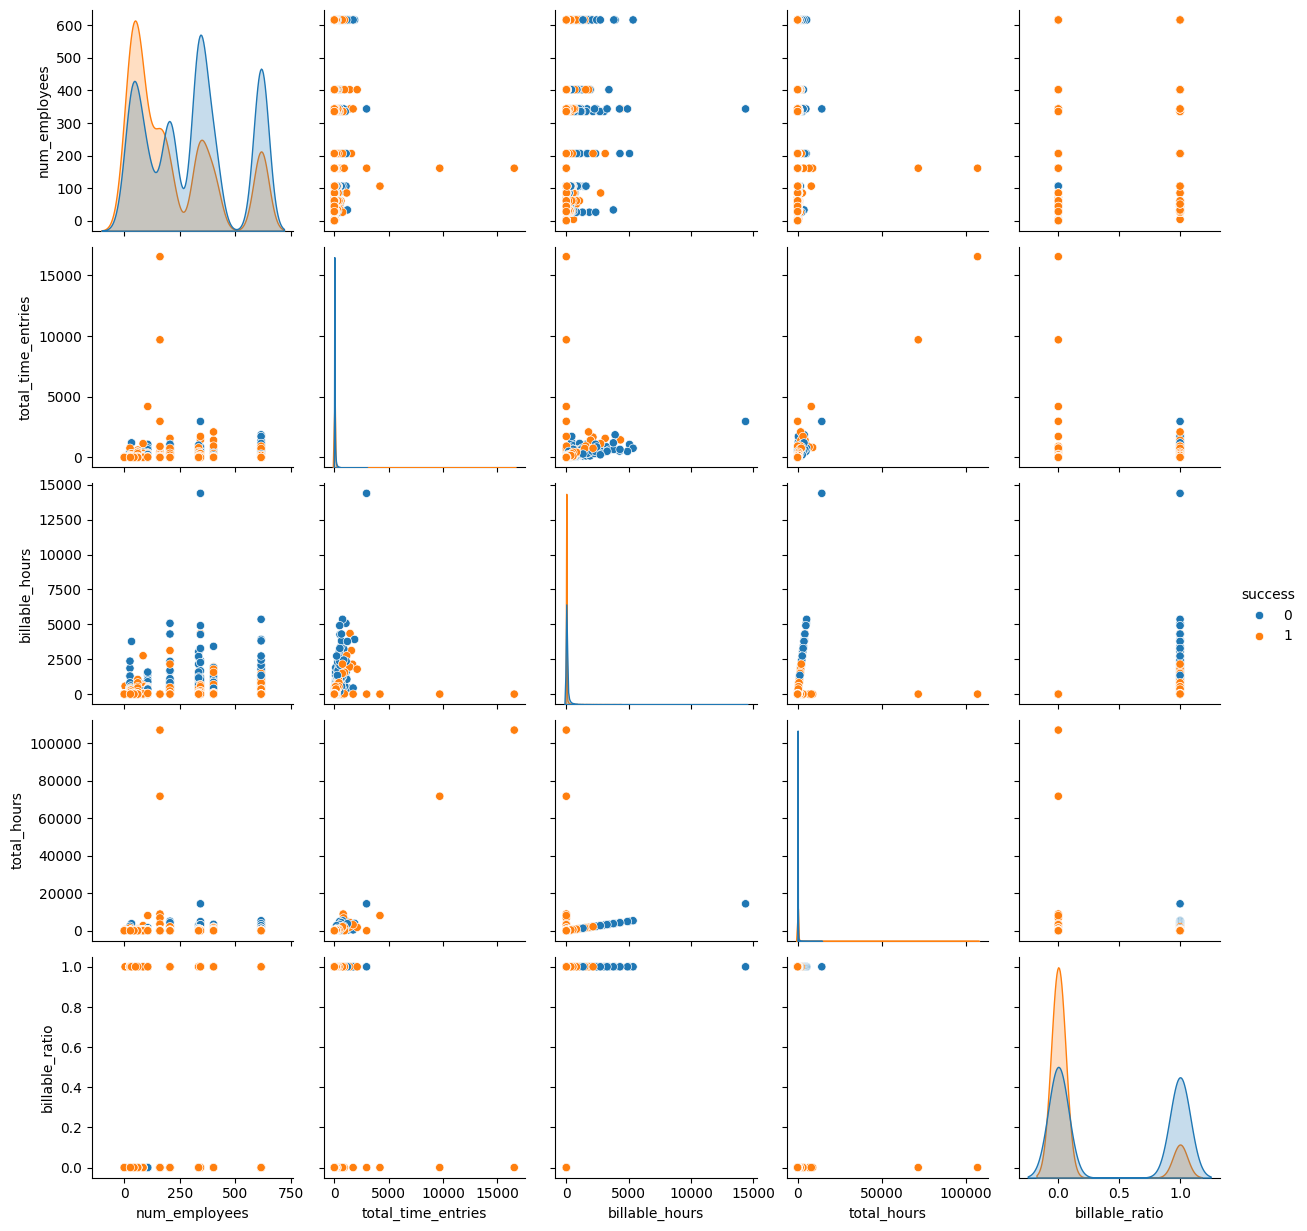


Accuracy Score: 0.6947981084030557

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72      1470
           1       0.68      0.65      0.67      1279

    accuracy                           0.69      2749
   macro avg       0.69      0.69      0.69      2749
weighted avg       0.69      0.69      0.69      2749



NameError: name 'confusion_matrix' is not defined

In [ ]:
import seaborn as sns   
df['success'] = df['project_status'].apply(lambda x: 1 if x == "Active" else 0)
df.drop(columns=['project_status'], inplace=True)

df.fillna(0, inplace=True)

sns.pairplot(df, hue="success")
plt.show()

X = df[['num_employees', 'total_time_entries', 'billable_hours', 'total_hours', 'billable_ratio']]
y = df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Confusion Matrix:
 [[1074  396]
 [ 443  836]]


C:\Users\lalit\AppData\Local\Temp\ipykernel_17220\1326533369.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')


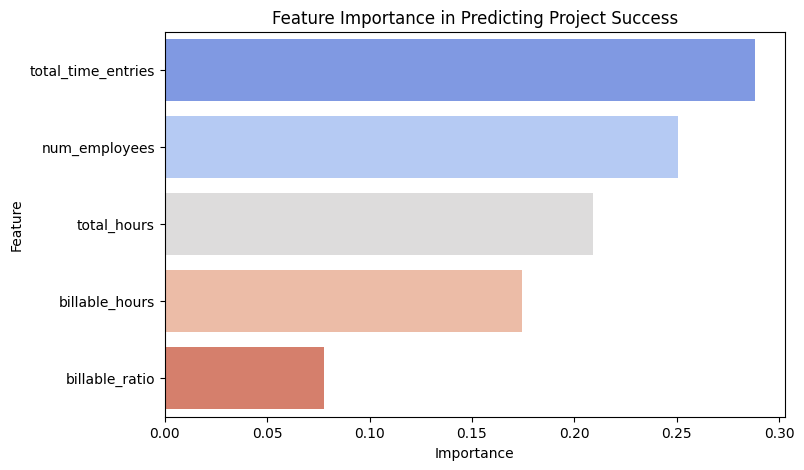

In [ ]:
from sklearn.metrics import confusion_matrix

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
plt.title("Feature Importance in Predicting Project Success")
plt.show()

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.6977082575481993

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72      1470
           1       0.69      0.65      0.67      1279

    accuracy                           0.70      2749
   macro avg       0.70      0.69      0.69      2749
weighted avg       0.70      0.70      0.70      2749



<Figure size 1000x600 with 0 Axes>

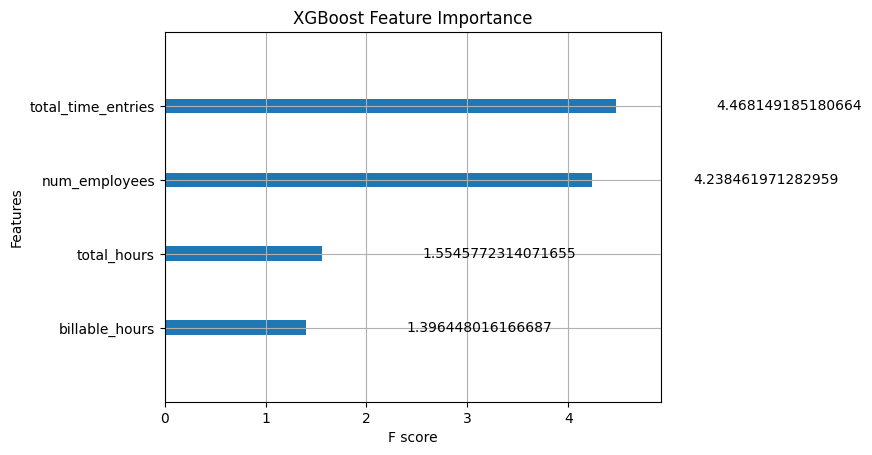

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_importance(model, importance_type='gain')
plt.title('XGBoost Feature Importance')
plt.show()


# Q4 How does an employee’s centrality in the coaching network correlate with their overall billable performance?

In [ ]:
#Creating a graph projection for employees based on the coaching relationships (treated as undirected)

#and calculate the PageRank centrality as centrality for each employee, get totalBillableHours and billingCount
'''

CALL gds.graph.project(
  "employeeGraph",
  "Employee",
  {
    IS_COACHED_BY: { orientation: "UNDIRECTED" }
  }
) YIELD graphName, nodeCount, relationshipCount;

CALL gds.pageRank.write("employeeGraph", {
  maxIterations: 20,
  dampingFactor: 0.85,
  writeProperty: "pagerankEmployee"
})
YIELD nodePropertiesWritten, ranIterations;
MATCH (e:Employee)
OPTIONAL MATCH (e)-[:CHARGES]->(t:Time)
WITH e, e.pagerankEmployee AS centrality, 
     sum(t.hours) AS totalBillableHours, 
     count(t) AS billingCount,
     e.target_ratio AS targetRatio
RETURN e.employee_id AS employeeId, 
       e.employee_name AS employeeName, 
       centrality, 
       totalBillableHours, 
       billingCount, 
       targetRatio

'''

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\nMATCH (e:Employee)\nOPTIONAL MATCH (e)-[:CHARGES]->(t:Time)\nWITH e, e.pagerankEmployee AS centrality, \n     sum(t.hours) AS totalBillableHours, \n     count(t) AS billingCount,\n     e.target_ratio AS targetRatio\nRETURN e.employee_id AS employeeId, \n       e.employee_name AS employeeName, \n       centrality, \n       totalBillableHours, \n       billingCount, \n       targetRatio\n'


Data loaded from Neo4j:
   employeeId         employeeName  centrality  totalBillableHours  \
0       10000        Michael Clark    0.517965              166.25   
1       10001       Matthew Murray    0.955891             1411.00   
2       10002           Peter Bray    1.353882             1049.25   
3       10003      Nancy Castaneda    0.503726             4839.50   
4       10004  Christopher Schmidt    0.550805             6695.50   

   billingCount  targetRatio  
0            53           85  
1          1180           75  
2           637           75  
3          1481           85  
4          2642           85  
Mean Squared Error: 505991.9004337119
Feature: centrality, Importance: 0.07347217373615128
Feature: billingCount, Importance: 0.7519751633152004
Feature: targetRatio, Importance: 0.17455266294864835


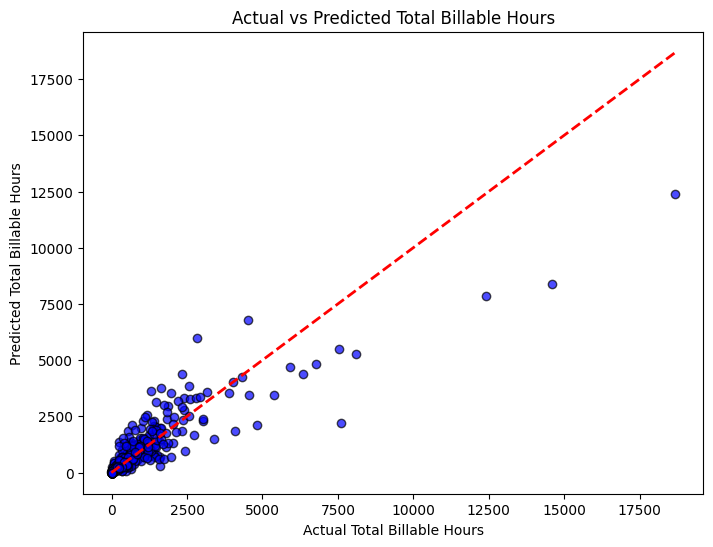

In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678"  #

cypher_query = """
MATCH (e:Employee)
OPTIONAL MATCH (e)-[:CHARGES]->(t:Time)
WITH e, e.pagerankEmployee AS centrality, 
     sum(t.hours) AS totalBillableHours, 
     count(t) AS billingCount,
     e.target_ratio AS targetRatio
RETURN e.employee_id AS employeeId, 
       e.employee_name AS employeeName, 
       centrality, 
       totalBillableHours, 
       billingCount, 
       targetRatio
"""

def fetch_employee_data(uri, user, pwd, query):
    driver = GraphDatabase.driver(uri, auth=(user, pwd))
    with driver.session() as session:
        results = session.run(query)
        data_records = [record.data() for record in results]
    driver.close()
    return data_records

records = fetch_employee_data(uri, username, password, cypher_query)

data = pd.DataFrame(records)

print("Data loaded from Neo4j:")
print(data.head())

features = data[['centrality', 'billingCount', 'targetRatio']]
labels = data['totalBillableHours']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

feature_importances = model.feature_importances_
for feature, importance in zip(features.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, predictions, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel("Actual Total Billable Hours")
plt.ylabel("Predicted Total Billable Hours")
plt.title("Actual vs Predicted Total Billable Hours")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, predictions)
print("R2:", r2)

R2: 0.7907274611580953


Mean Squared Error: 685442.0698319019
R2 0.7165088965656985
Feature: centrality, Importance: 0.051528528332710266
Feature: billingCount, Importance: 0.574018120765686
Feature: targetRatio, Importance: 0.3744533061981201


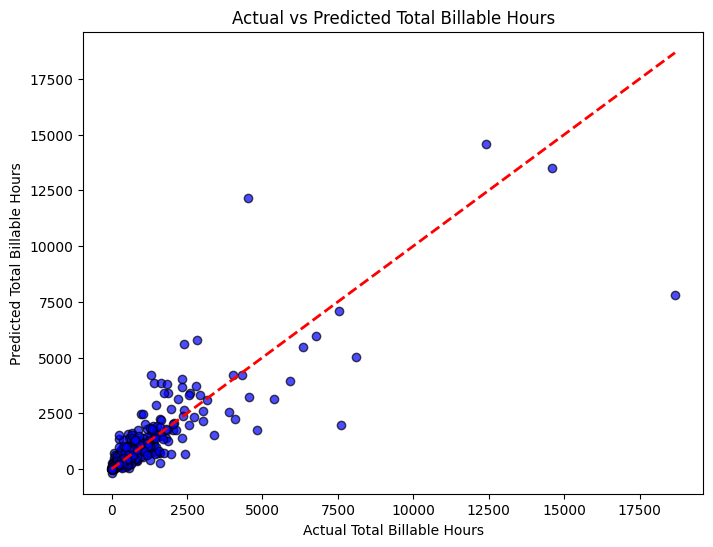

In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, predictions)
print("R2", r2)

feature_importances = model.feature_importances_
for feature, importance in zip(features.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, predictions, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel("Actual Total Billable Hours")
plt.ylabel("Predicted Total Billable Hours")
plt.title("Actual vs Predicted Total Billable Hours")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()


Dominance of Billing Activity: The fact that billingCount overwhelmingly influences the model indicates that the sheer number of billing transactions is the primary factor in determining an employee's total billable hours.

Role of Target Expectations: targetRatio also plays a meaningful role. This may reflect managerial or contractual expectations that align with observed outcomes, reinforcing that employees with higher target ratios tend to have more billable hours.

More Limited Impact of Network Centrality: While centrality (derived from coaching relationships) is statistically significant—it does contribute to the explanation—it has a relatively small effect compared to billing behavior and target expectations. This suggests that while being well-connected in the mentoring network might have benefits, it appears secondary to the direct measures of billing activity in this model.

Concluding Thoughts
Practical Implications: For organizational strategy, these results suggest that while fostering effective coaching relationships is important, focusing on increasing productive billing activity (reflected in billingCount) and aligning internal target expectations can have a more pronounced impact on total billable performance.

Further Investigation: It might be worthwhile to explore if there are indirect effects of network centrality on outcomes—for example, if centrality influences billing behavior over time or interacts with other variables not currently in the model. Alternatively, more sophisticated modeling (or incorporating additional network features) could further clarify the role of coaching relationships.

# Q5 How does partner status moderate the relationship between an employee’s centrality in the coaching network and their overall billable performance?



In [ ]:
# Creating a graph projection for employees based on the coaching relationships (treated as undirected) 
# and calculate the PageRank centrality as centrality for each employee, get totalBillableHours and billingCount

'''
MATCH (e:Employee)
OPTIONAL MATCH (e)-[:CHARGES]->(t:Time)
WITH e, e.pagerankEmployee AS centrality, 
     sum(t.hours) AS totalBillableHours, 
     count(t) AS billingCount,
     e.target_ratio AS targetRatio,
     e.partner AS partnerStatus
RETURN e.employee_id AS employeeId, 
       e.employee_name AS employeeName, 
       centrality, 
       totalBillableHours, 
       billingCount, 
       targetRatio,
       partnerStatus
'''

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\nMATCH (e:Employee)\nOPTIONAL MATCH (e)-[:CHARGES]->(t:Time)\nWITH e, e.pagerankEmployee AS centrality, \n     sum(t.hours) AS totalBillableHours, \n     count(t) AS billingCount,\n     e.target_ratio AS targetRatio,\n     e.partner AS partnerStatus\nRETURN e.employee_id AS employeeId, \n       e.employee_name AS employeeName, \n       centrality, \n       totalBillableHours, \n       billingCount, \n       targetRatio,\n       partnerStatus\n'


Data loaded from Neo4j:
   employeeId         employeeName  centrality  totalBillableHours  \
0       10000        Michael Clark    0.517965              166.25   
1       10001       Matthew Murray    0.955891             1411.00   
2       10002           Peter Bray    1.353882             1049.25   
3       10003      Nancy Castaneda    0.503726             4839.50   
4       10004  Christopher Schmidt    0.550805             6695.50   

   billingCount  targetRatio  partnerStatus  
0            53           85              0  
1          1180           75              0  
2           637           75              1  
3          1481           85              0  
4          2642           85              0  
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
272 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lalit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c

Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Negative MSE (from CV): -679354.2809204396
Test Mean Squared Error: 507874.1830428959
Feature: centrality, Importance: 0.18366746097268175
Feature: billingCount, Importance: 0.6377489983717383
Feature: targetRatio, Importance: 0.14672671276970545
Feature: partnerStatus, Importance: 0.0318568278858747


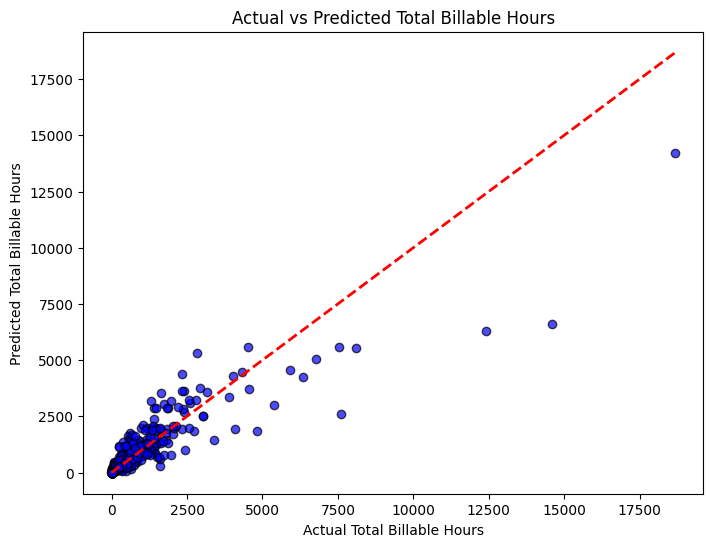

In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678"  

cypher_query = """
MATCH (e:Employee)
OPTIONAL MATCH (e)-[:CHARGES]->(t:Time)
WITH e, e.pagerankEmployee AS centrality, 
     sum(t.hours) AS totalBillableHours, 
     count(t) AS billingCount,
     e.target_ratio AS targetRatio,
     e.partner AS partnerStatus
RETURN e.employee_id AS employeeId, 
       e.employee_name AS employeeName, 
       centrality, 
       totalBillableHours, 
       billingCount, 
       targetRatio,
       partnerStatus
"""

def fetch_employee_data(uri, user, pwd, query):
    driver = GraphDatabase.driver(uri, auth=(user, pwd))
    with driver.session() as session:
        results = session.run(query)
        data_records = [record.data() for record in results]
    driver.close()
    return data_records

records = fetch_employee_data(uri, username, password, cypher_query)
data = pd.DataFrame(records)
print("Data loaded from Neo4j:")
print(data.head())

data['partnerStatus'] = data['partnerStatus'].astype(int)

features = data[['centrality', 'billingCount', 'targetRatio', 'partnerStatus']]
labels = data['totalBillableHours']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Negative MSE (from CV):", grid_search.best_score_)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Test Mean Squared Error:", mse)

feature_importances = best_model.feature_importances_
for feature, importance in zip(features.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, predictions, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel("Actual Total Billable Hours")
plt.ylabel("Predicted Total Billable Hours")
plt.title("Actual vs Predicted Total Billable Hours")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()


In [18]:
r2 = r2_score(y_test, predictions)
print("Test Mean Squared Error:", r2)

Test Mean Squared Error: 0.7899489703164351


while being a partner or non‑partner might have other strategic or cultural implications in your organization, when it comes to predicting total billable hours, the more direct indicators (billing transactions, network centrality, and target expectations) are far more influential.